In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

C:\Users\angel\my_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Chargement des labels

In [2]:
df = pd.read_csv('train.txt', sep='\t', header=None, names=['filename', 'class', 'gender'])
df['filename'] = df['filename'].apply(lambda x: f'train/{x}')
# Convert labels from -1, 1 to '0', '1' (as strings)
df['class'] = df['class'].replace(-1, '0').replace(1, '1')

In [3]:
df.head()

,filename,class,gender
0,train/000000.jpg,0,-1
1,train/000001.jpg,1,-1
2,train/000002.jpg,0,-1
3,train/000003.jpg,0,1
4,train/000004.jpg,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192576 entries, 0 to 192575
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  192576 non-null  object
 1   class     192576 non-null  object
 2   gender    192576 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.4+ MB


# Prétraitement des données

In [5]:
# vérifier l'équilibre
print("Equilibre des genres :", np.unique(df["gender"], return_counts=True)) # label de genre -1: femme 1: homme
print("Equilibre des classes :", np.unique(df["class"], return_counts=True)) # class à prédire

Equilibre des genres : (array([-1,  1], dtype=int64), array([113154,  79422], dtype=int64))
Equilibre des classes : (array(['0', '1'], dtype=object), array([155435,  37141], dtype=int64))


Les Femmes sont sur-représenté : 113154 contre 79422 pour les hommes
La classe majoritaire est "0" et la classe minoritaire est "1"
Cherchons d'abord à équilibrer la proportion homme/femme

In [6]:
women = df[df["gender"] == -1]
women["class"].value_counts()

0    85507
1    27647
Name: class, dtype: int64

In [7]:
men = df[df["gender"] == 1]
men["class"].value_counts()

0    69928
1     9494
Name: class, dtype: int64

## Sous-échantillonage de la classe Femme

In [8]:
women_under = women.sample(len(men))
df_balanced = pd.concat([women_under, men])
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158844 entries, 167837 to 192574
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  158844 non-null  object
 1   class     158844 non-null  object
 2   gender    158844 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.8+ MB


In [9]:
# vérifier l'équilibre
print("Equilibre des genres :", np.unique(df_balanced["gender"], return_counts=True)) # label de genre -1: femme 1: homme
print("Equilibre des classes :", np.unique(df_balanced["class"], return_counts=True)) # class à prédire

Equilibre des genres : (array([-1,  1], dtype=int64), array([79422, 79422], dtype=int64))
Equilibre des classes : (array(['0', '1'], dtype=object), array([130088,  28756], dtype=int64))


In [10]:
women_balanced = df_balanced[df_balanced["gender"] == -1]
women_balanced["class"].value_counts()

0    60160
1    19262
Name: class, dtype: int64

In [11]:
men_balanced = df_balanced[df_balanced["gender"] == 1]
men_balanced["class"].value_counts()

0    69928
1     9494
Name: class, dtype: int64

On décide de garder le désiquilibre des classes

## normalisation

## Séparer les données en trois ensemble : entraînement, validation et test

In [12]:
from sklearn.model_selection import train_test_split

# Séparer les données en 2 ensembles : entraînement+validation et test
temp_df, test_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced["gender"])

# Séparer entraînement+validation en 2 ensembles : entraînement et validation
train_df, val_df = train_test_split(temp_df, test_size=0.25, stratify=temp_df["gender"])  # 0.25 x 0.8 = 0.2

In [13]:
# Equilibre entrainement, validation, test
print("Equilibre genre base entrainement :", np.unique(train_df["gender"], return_counts=True)) # label de genre -1: femme 1: homme
print("Equilibre classe base entrainement :", np.unique(train_df["class"], return_counts=True)) # label de genre -1: femme 1: homme
print("\n")

print("Equilibre genre base de validation :", np.unique(val_df["gender"], return_counts=True)) # label de genre -1: femme 1: homme
print("Equilibre classe base de validation :", np.unique(val_df["class"], return_counts=True)) # label de genre -1: femme 1: homme
print("\n")

print("Equilibre genre base de test :", np.unique(test_df["gender"], return_counts=True)) # label de genre -1: femme 1: homme
print("Equilibre classe base de test :", np.unique(test_df["class"], return_counts=True)) # label de genre -1: femme 1: homme

Equilibre genre base entrainement : (array([-1,  1], dtype=int64), array([47653, 47653], dtype=int64))
Equilibre classe base entrainement : (array(['0', '1'], dtype=object), array([78133, 17173], dtype=int64))


Equilibre genre base de validation : (array([-1,  1], dtype=int64), array([15885, 15884], dtype=int64))
Equilibre classe base de validation : (array(['0', '1'], dtype=object), array([25989,  5780], dtype=int64))


Equilibre genre base de test : (array([-1,  1], dtype=int64), array([15884, 15885], dtype=int64))
Equilibre classe base de test : (array(['0', '1'], dtype=object), array([25966,  5803], dtype=int64))


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Créer un ImageDataGenerator pour la normalisation
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Pondération
train_df['gender_mapped'] = train_df['gender'].map({-1: 1, 1: 0.1})

In [103]:
# Créer les générateurs pour l'entraînement, la validation et le test

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,  # Aucun répertoire racine, les chemins sont déjà complets dans le DataFrame
    x_col='filename',  # Colonne contenant les chemins des fichiers
    y_col='class',     # Colonne contenant les labels des classes
    target_size=(80, 80),
    batch_size=32,
    class_mode='binary',
   weight_col='gender_mapped'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,  # Aucun répertoire racine, les chemins sont déjà complets dans le DataFrame
    x_col='filename',  # Colonne contenant les chemins des fichiers
    y_col='class',     # Colonne contenant les labels des classes
    target_size=(80, 80),
    batch_size=32,
    class_mode='binary', # 'binary' pour la classification binaire
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,  # Aucun répertoire racine, les chemins sont déjà complets dans le DataFrame
    x_col='filename',  # Colonne contenant les chemins des fichiers
    y_col='class',     # Colonne contenant les labels des classes
    target_size=(80, 80),
    batch_size=32,
    class_mode='binary',  # 'binary' pour la classification binaire
    shuffle=False
)

Found 95306 validated image filenames belonging to 2 classes.
Found 31769 validated image filenames belonging to 2 classes.
Found 31769 validated image filenames belonging to 2 classes.


In [141]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Architecture du modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sortie binaire
])

In [17]:
# Configurer Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='min')

In [116]:
# Créer une instance de BinaryFocalCrossentropy
focal_loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=5.0, alpha=0.25)

In [166]:
# Compilation du modèle
model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy'])

## Entraînement

In [167]:
# Entraînement du modèle
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Nombre d'étapes par époque
    epochs=10,  # Nombre d'époques
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

Epoch 1/10
2979/2979 [==============================] - 428s 143ms/step - loss: 0.0046 - accuracy: 0.8976 - val_loss: 0.0085 - val_accuracy: 0.8984
Epoch 2/10
2979/2979 [==============================] - 399s 134ms/step - loss: 0.0044 - accuracy: 0.9044 - val_loss: 0.0085 - val_accuracy: 0.9044
Epoch 3/10
2979/2979 [==============================] - 441s 148ms/step - loss: 0.0043 - accuracy: 0.9097 - val_loss: 0.0073 - val_accuracy: 0.9169
Epoch 4/10
2979/2979 [==============================] - 442s 148ms/step - loss: 0.0042 - accuracy: 0.9137 - val_loss: 0.0072 - val_accuracy: 0.9183
Epoch 5/10
2979/2979 [==============================] - 445s 149ms/step - loss: 0.0041 - accuracy: 0.9151 - val_loss: 0.0073 - val_accuracy: 0.9158
Epoch 5: early stopping


In [62]:
# Sauvegarde du modèle
model.save('model_cnn_faces.keras')

In [72]:
# Sauvegarde de l'historique
import json
history_dict = history.history

# Sauvegarder en tant que JSON
with open('model_history.json', 'w') as file:
    json.dump(history_dict, file)

## Evaluation

In [168]:
# Évaluation sur l'ensemble de test (population totale : homme + femme)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

993/993 [==============================] - 41s 42ms/step - loss: 0.0073 - accuracy: 0.9138
Test Loss: 0.007340311538428068, Test Accuracy: 0.9138468503952026


In [159]:
# Séparation des données de test par genre
test_df_women = test_df[test_df['gender'] == -1]
test_df_men = test_df[test_df['gender'] == 1]

In [96]:
# Création des générateurs pour les femmes et les hommes

test_generator_women = datagen.flow_from_dataframe(
    dataframe=test_df_women,
    directory=None,
    x_col='filename',
    y_col='class',
    class_mode='binary',
    target_size=(80, 80),
    batch_size=32,
    shuffle=False  # Important pour garder l'ordre pour l'évaluation
)

test_generator_men = datagen.flow_from_dataframe(
    dataframe=test_df_men,
    directory=None,
    x_col='filename',
    y_col='class',
    class_mode='binary',
    target_size=(80, 80),
    batch_size=32,
    shuffle=False
)

Found 15884 validated image filenames belonging to 2 classes.
Found 15885 validated image filenames belonging to 2 classes.


In [169]:
# Évaluation sur les femmes
test_loss_women, test_accuracy_women = model.evaluate(test_generator_women)

# Évaluation sur les hommes
test_loss_men, test_accuracy_men = model.evaluate(test_generator_men)

# Imprimez ou enregistrez les résultats
print(f"Performance sur les Femmes - Loss: {test_loss_women}, Accuracy: {test_accuracy_women}")
print(f"Performance sur les Hommes - Loss: {test_loss_men}, Accuracy: {test_accuracy_men}")

497/497 [==============================] - 13s 26ms/step - loss: 0.0069 - accuracy: 0.9203
Performance sur les Femmes - Loss: 0.00782778486609459, Accuracy: 0.9073910713195801
Performance sur les Hommes - Loss: 0.006852862890809774, Accuracy: 0.920302152633667


In [170]:
Fair_Metric = np.mean([test_accuracy_women, test_accuracy_men]) - (2*np.abs(test_accuracy_women - test_accuracy_men))
Fair_Metric

0.8880244493484497

## Analyse de la performance

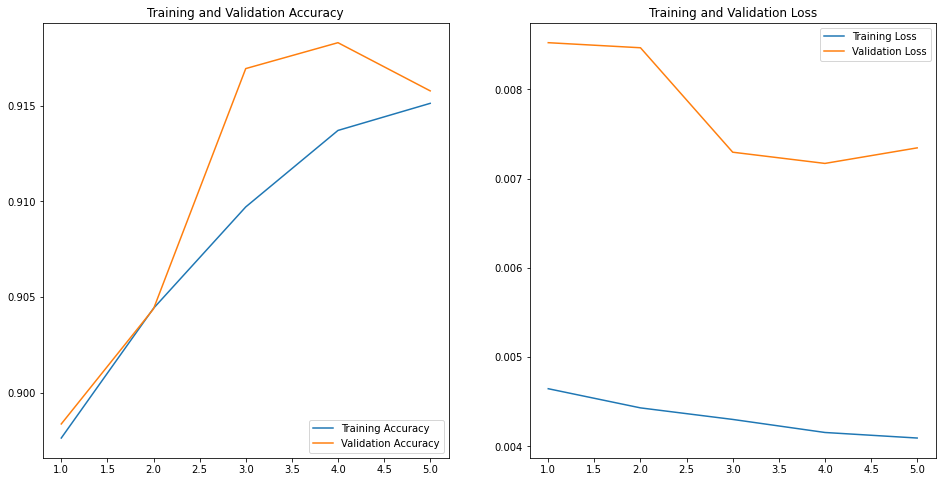

In [180]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1,6)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 42ms/step


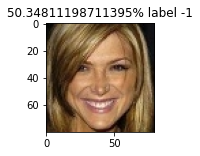

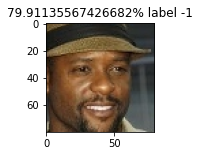

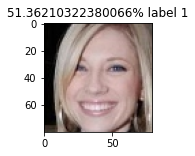

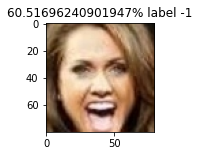

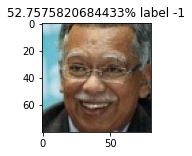

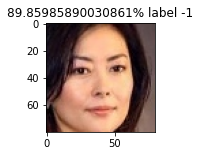

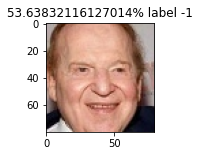

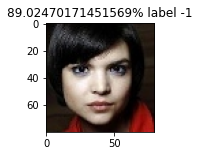

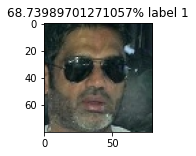

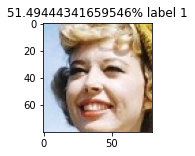

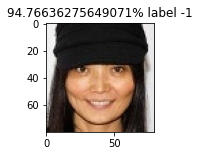

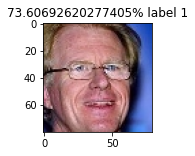

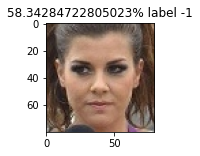

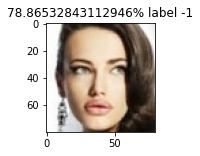

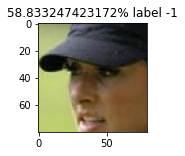

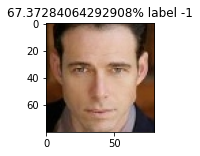

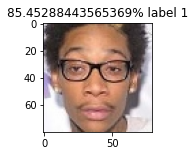

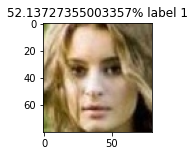

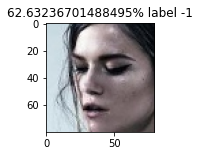

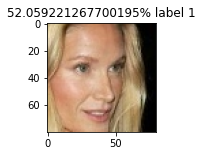

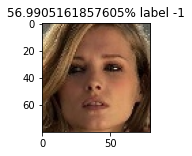

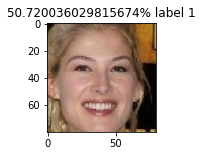

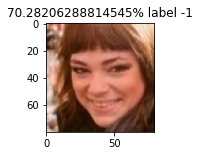

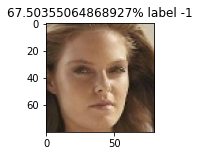

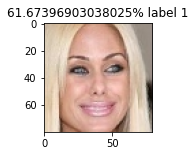

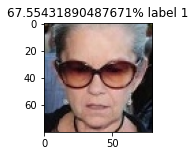

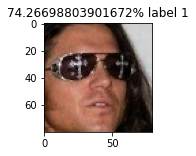

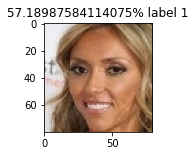

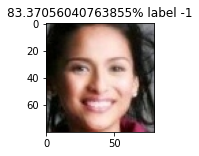

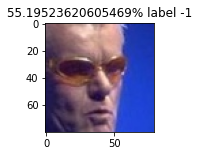

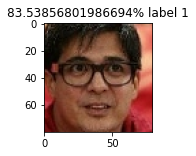

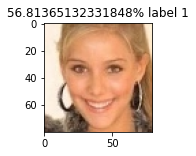

In [182]:
import matplotlib.pyplot as plt

# Réinitialiser le générateur
pred_generator.reset()

# Nombre de lots à traiter
nombre_lots = 1

# Initialisation du compteur de lots
compteur_lots = 0

# Itérer sur le générateur
for images_batch in pred_generator:
    # Faire des prédictions pour le lot actuel
    predictions = model.predict(images_batch)
    #probabilities = [1 if pred > 0.5 else -1 for pred in predictions]
    
    # Itérer sur chaque image et prédiction dans le lot
    for i in range(images_batch.shape[0]):
        plt.figure(figsize=(2, 2))  # Taille de l'image
        plt.imshow(images_batch[i])  # Afficher l'image
        if predictions[i] > 0.5:
            plt.title(f"{float(predictions[i][0])*100}% label 1")
        else:
            plt.title(f"{float(1-predictions[i][0])*100}% label -1")        
        plt.show()
    # Incrémenter le compteur de lots
    compteur_lots += 1

    # Vérifier si le nombre spécifié de lots a été traité
    if compteur_lots >= nombre_lots:
        break
